<a href="https://colab.research.google.com/github/nourshmm/analyse-de-sentiments/blob/master/Analyse_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd 
import re
import nltk

In [9]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
data = pd.read_csv("/content/gdrive/My Drive/deep learning//dataset/Sentiment.csv")
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

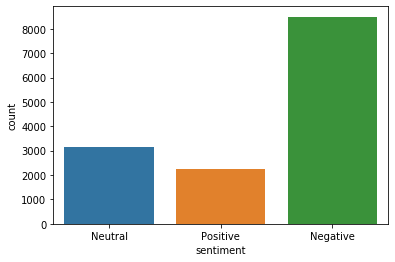

In [12]:
sns.countplot(x='sentiment', data=data)


In [0]:
data = data[['text','sentiment']]

In [0]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
      

In [15]:
pos = data[data.sentiment == "Positive"]
neg = data[data.sentiment == "Negative"]
neg.head()

,text,sentiment
6,RT @warriorwoman91: I liked her and was happy ...,Negative
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative
9,RT @NancyOsborne180: Last night's debate prove...,Negative
10,@JGreenDC @realDonaldTrump In all fairness #Bi...,Negative
12,Me reading my family's comments about how grea...,Negative


In [16]:
X_val_model_pos =  data.iloc[[1, 3, 4, 5]] 
X_val_model_neg =  data.iloc[[6, 8, 9, 10]] 
print(len(data))

13871


In [0]:
data = data.drop(data.index[[1, 3, 4, 5]])
data = data.drop(data.index[[6, 8, 9, 10]])

In [0]:
X_val_model_pos = X_val_model_pos.iloc[:, data.columns != 'sentiment']
X_val_model_neg = X_val_model_neg.iloc[:, data.columns != 'sentiment']

X_val_model_pos = np.array(X_val_model_pos)
X_val_model_neg = np.array(X_val_model_neg)

print(len(data))

13863


In [0]:
13871 - 13863

8

In [0]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4462
16982


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

print("data Training :",X_train.shape,Y_train.shape)
print("data Testing :",X_test.shape,Y_test.shape)

data Training : (7183, 28) (7183, 2)
data Testing : (3539, 28) (3539, 2)


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical


In [0]:
X.shape[1]

28

In [0]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 196)               254800    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.fit(X_train, Y_train, epochs = 7, batch_size=32)

Epoch 1/7
7183/7183 [==============================] - 21s 3ms/step - loss: 0.4368 - acc: 0.8158
Epoch 2/7
7183/7183 [==============================] - 19s 3ms/step - loss: 0.3203 - acc: 0.8657
Epoch 3/7
7183/7183 [==============================] - 19s 3ms/step - loss: 0.2751 - acc: 0.8838
Epoch 4/7
7183/7183 [==============================] - 19s 3ms/step - loss: 0.2441 - acc: 0.9013
Epoch 5/7
7183/7183 [==============================] - 19s 3ms/step - loss: 0.2248 - acc: 0.9090
Epoch 6/7
7183/7183 [==============================] - 19s 3ms/step - loss: 0.1988 - acc: 0.9179
Epoch 7/7
7183/7183 [==============================] - 19s 3ms/step - loss: 0.1819 - acc: 0.9258


In [0]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.48
acc: 0.85


In [0]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 54.32098765432099 %
neg_acc 93.02721088435374 %


# Validation de model avec des donnes jamais vu par le model 

In [0]:
def validation_tweets(model, tweets):
  for twt in tweets:
    print(twt)
    twt = tokenizer.texts_to_sequences(twt)
    twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
    #print(twt)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    if(np.argmax(sentiment) == 0):
        print("negative")
    elif (np.argmax(sentiment) == 1):
        print("positive")

## Donnes des tweets negative : 
*X_val_model_neg*

In [0]:
validation_tweets(model, X_val_model_neg)

['RT @warriorwoman91: I liked her and was happy when I heard she was going to be the moderator. Not anymore. #GOPDebate @megynkelly  https://…']
negative
['Deer in the headlights RT @lizzwinstead: Ben Carson, may be the only brain surgeon who has performed a lobotomy on himself. #GOPDebate']
negative
["RT @NancyOsborne180: Last night's debate proved it! #GOPDebate #BATsAsk @BadassTeachersA #TBATs  https://t.co/G2gGjY1bJD"]
negative
['@JGreenDC @realDonaldTrump In all fairness #BillClinton owns that phrase.#GOPDebate']
negative


## Donnes des tweets positive :
*X_val_model_pos*

In [0]:
validation_tweets(model, X_val_model_pos)

["RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…"]
negative
["RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …"]
negative
['RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…']
positive
['RT @GregAbbott_TX: @TedCruz: "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate @FoxNews']
positive
